In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [35]:
df = pd.read_csv('../data/processed/preprocessed_dataset.csv')
df.head()

,title,year,imdb_id,rating_count,rating,genre,keywords,actors,director,processed_plot
0,Gladiator,2000,tt0172495,1617220,8.5,"['Action', 'Adventure', 'Drama']","['roman empire', 'gladiator', 'slavery', 'comb...","['Russell Crowe', 'Joaquin Phoenix', 'Connie N...",['Ridley Scott'],shouting rom invicta force attack general maxi...
1,Unbreakable,2000,tt0217869,440860,7.3,"['Drama', 'Mystery', 'Sci-Fi']","['supernatural power', 'train crash', 'superhe...","['Bruce Willis', 'Samuel L. Jackson', 'Robin W...",['M. Night Shyamalan'],film open see baby born west philadelphia elij...
2,Snatch,2000,tt0208092,909299,8.2,"['Comedy', 'Crime']","['diamond', 'boxer', 'narrated by character', ...","['Jason Statham', 'Brad Pitt', 'Stephen Graham']",['Guy Ritchie'],stealing carat g diamond heist antwerp franki...
3,AmericanPsycho,2000,tt0144084,713635,7.6,"['Crime', 'Drama', 'Horror']","['narcissism', 'materialism', 'serial murder',...","['Christian Bale', 'Justin Theroux', 'Josh Luc...",['Mary Harron'],white background red drop begin fall past open...
4,RequiemforaDream,2000,tt0180093,897414,8.3,['Drama'],"['drug addiction', 'sex show', 'sex scene', 'p...","['Ellen Burstyn', 'Jared Leto', 'Jennifer Conn...",['Darren Aronofsky'],harry goldfarb jared leto tyrone love marlon w...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7553 entries, 0 to 7552
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           7553 non-null   object 
 1   year            7553 non-null   int64  
 2   imdb_id         7553 non-null   object 
 3   rating_count    7553 non-null   int64  
 4   rating          7553 non-null   float64
 5   genre           7553 non-null   object 
 6   keywords        7553 non-null   object 
 7   actors          7553 non-null   object 
 8   director        7553 non-null   object 
 9   processed_plot  7553 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 590.2+ KB


In [10]:
df.isnull().sum()

title             0
year              0
imdb_id           0
rating_count      0
rating            0
genre             0
keywords          0
actors            0
director          0
processed_plot    0
dtype: int64

In [11]:
features = ['title', 'genre', 'actors', 'director', 'keywords', 'processed_plot', 'rating_count']

In [12]:
X = df[features]
y = df['rating']  

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Define custom transformer for genre, actors, and director
class ListFlattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([' '.join(lst) for lst in X]).reshape(-1, 1)

In [15]:
# apply ListFlattener to genre first row
ListFlattener().fit_transform(X_train['genre'][:1])

array([["[ ' B i o g r a p h y ' ,   ' D r a m a ' ,   ' M u s i c ' ]"]],
      dtype='<U61')

In [16]:
titles = df['title'].tolist()
descriptions = df['processed_plot'].tolist()

In [17]:
glove_file = 'glove.6B.100d.txt'

In [18]:
embedding_size = 100
word_embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.array(values[1:], dtype='float32')
        word_embeddings[word] = embedding

In [19]:
def text_to_embeddings(text):
    words = text.split()
    embeddings = np.zeros(embedding_size)
    count = 0
    for word in words:
        if word in word_embeddings:
            embeddings += word_embeddings[word]
            count += 1
    if count != 0:
        embeddings /= count
    return embeddings

In [20]:
movie_embeddings = np.array([text_to_embeddings(desc) for desc in descriptions])

In [21]:
# Cluster embeddings using K-means
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(movie_embeddings)

/Users/hemantrajsingh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
# Preprocess input description
input_description = "batman fights crime in gotham city"
input_embedding = text_to_embeddings(input_description)

# Find cluster of input description
input_cluster = kmeans.predict([input_embedding])[0]

# Get indices of movies in the same cluster as input
cluster_indices = [i for i, label in enumerate(cluster_labels) if label == input_cluster]
recommended_movies = X.iloc[cluster_indices]

print("Recommended Movies:")
print(recommended_movies.title)

Recommended Movies:
28                  Traffic
56             ThirteenDays
57             RomeoMustDie
66        RulesofEngagement
75         BeforeNightFalls
               ...         
7533                Shirley
7536    TheTruthvsAlexJones
7539     TheBloodyHundredth
7550               Reloaded
7552      IrklaisperAtlanta
Name: title, Length: 622, dtype: object


/Users/hemantrajsingh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/hemantrajsingh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/hemantrajsingh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/hemantrajsingh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

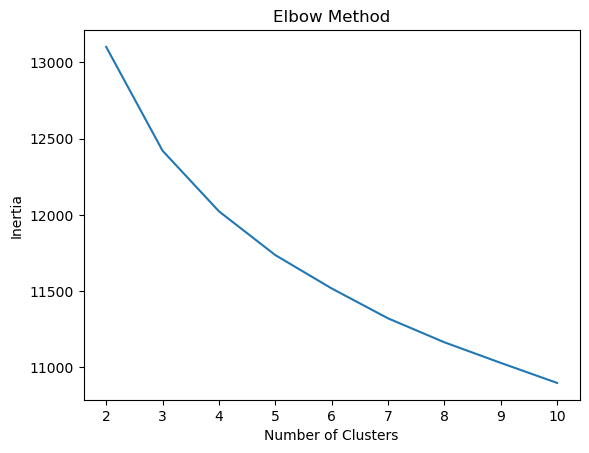

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(movie_embeddings)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.plot(range(2, 11), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [33]:
# Fit K-means with optimal number of clusters
optimal_n_clusters = 3  
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
labels = kmeans.fit_predict(movie_embeddings)

# Display clusters
for cluster_id in range(optimal_n_clusters):
    cluster_indices = np.where(labels == cluster_id)[0]
    cluster_movies = X.iloc[cluster_indices]
    print(f"Cluster {cluster_id + 1} Movies:")
    print()


TypeError: float() argument must be a string or a real number, not 'dict'

In [40]:
df.head()

,title,year,imdb_id,rating_count,rating,genre,keywords,actors,director,processed_plot,text_features
0,Gladiator,2000,tt0172495,1617220,8.5,"['Action', 'Adventure', 'Drama']","['roman empire', 'gladiator', 'slavery', 'comb...","['Russell Crowe', 'Joaquin Phoenix', 'Connie N...",['Ridley Scott'],shouting rom invicta force attack general maxi...,"['Action', 'Adventure', 'Drama'] ['Ridley Scot..."
1,Unbreakable,2000,tt0217869,440860,7.3,"['Drama', 'Mystery', 'Sci-Fi']","['supernatural power', 'train crash', 'superhe...","['Bruce Willis', 'Samuel L. Jackson', 'Robin W...",['M. Night Shyamalan'],film open see baby born west philadelphia elij...,"['Drama', 'Mystery', 'Sci-Fi'] ['M. Night Shya..."
2,Snatch,2000,tt0208092,909299,8.2,"['Comedy', 'Crime']","['diamond', 'boxer', 'narrated by character', ...","['Jason Statham', 'Brad Pitt', 'Stephen Graham']",['Guy Ritchie'],stealing carat g diamond heist antwerp franki...,"['Comedy', 'Crime'] ['Guy Ritchie'] ['Jason St..."
3,AmericanPsycho,2000,tt0144084,713635,7.6,"['Crime', 'Drama', 'Horror']","['narcissism', 'materialism', 'serial murder',...","['Christian Bale', 'Justin Theroux', 'Josh Luc...",['Mary Harron'],white background red drop begin fall past open...,"['Crime', 'Drama', 'Horror'] ['Mary Harron'] [..."
4,RequiemforaDream,2000,tt0180093,897414,8.3,['Drama'],"['drug addiction', 'sex show', 'sex scene', 'p...","['Ellen Burstyn', 'Jared Leto', 'Jennifer Conn...",['Darren Aronofsky'],harry goldfarb jared leto tyrone love marlon w...,['Drama'] ['Darren Aronofsky'] ['Ellen Burstyn...


In [42]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Combine relevant columns for text-based features
df["text_features"] = df["genre"] + " " + df["director"] + " " + df["actors"] + " " + df["processed_plot"]

# Vectorize text features using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["text_features"])

# Standardize numerical features (rating and vote_count)
scaler = StandardScaler()
X_scaled = np.hstack([X.toarray(), scaler.fit_transform(df[["rating", "rating_count"]])])

# Initialize KMeans with desired number of clusters
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans to the combined features
kmeans.fit(X_scaled)

# Add cluster labels to the dataframe
df["cluster"] = kmeans.labels_

# Print the movies in each cluster
for cluster_id in range(num_clusters):
    cluster_movies = df[df["cluster"] == cluster_id]["title"].tolist()
    print(f"Cluster {cluster_id}: {', '.join(cluster_movies)}")


/Users/hemantrajsingh/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0: BringItOn, Days, Bedazzled, RomeoMustDie, NextFriday, Shaft, TheKid, ProofofLife, SkippedParts, CecilBDemented, TheTiggerMovie, PsychoBeachParty, RugratsinParis, Duets, Love&Sex, Maze, AFishTale, TheGuilty, Digimon:TheMovie, NurseBetty, OrdinaryDecentCriminal, TheClaim, WheretheMoneyIs, Lockdown, ChainofFools, AShotatGlory, Timecode, EverythingPutTogether, God'sArmy, PriceofGlory, Jericho, Sorted, Takedown, UpattheVilla, TerrorTract, StrangerThanFiction, AnEverlastingPiece, Bruno, BeyondSuspicion, Ricky, RedDirt, Bootmen, TheKingIsAlive, ChasingSleep, StealThisMovie, Lakeboat, CowboysandAngels, ThePrimeGig, BossaNova, WhentheSkyFalls, NakedStates, TheMagicofMarciano, EverythingforaReason, ShallowHal, OriginalSin, TheMexican, JoeDirt, Heartbreakers, SavetheLastDance, OsmosisJones, RockStar, HowHigh, KnockaroundGuys, SomeoneLikeYou, OutCold, JimmyNeutron:BoyGenius, O, Don'tSayaWord, TheTailorofPanama, MilestoGraceland, Formula, ProzacNation, OneNightatMcCool's, BlowDry, Antitr

In [47]:
user_scenario = "batman fights crime in gotham city"
num_recommendations=5
recommended_movies
# Transform user scenario into an embedding
user_embedding = vectorizer.transform([user_scenario])
user_embedding_scaled = np.hstack([user_embedding.toarray(), scaler.transform([[0, 0]])])

# Predict the cluster for the user scenario
user_cluster = kmeans.predict(user_embedding_scaled)[0]

# Get movies from the same cluster as the user scenario
recommended_movies = df[df["cluster"] == user_cluster]["title"].tolist()

# Exclude the user scenario movie (if it exists in the dataset)
recommended_movies = [movie for movie in recommended_movies if movie.lower() != user_scenario.lower()]

# Return the top N recommended movies
print(recommended_movies[:num_recommendations])

['BringItOn', 'Days', 'Bedazzled', 'RomeoMustDie', 'NextFriday']


/Users/hemantrajsingh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
